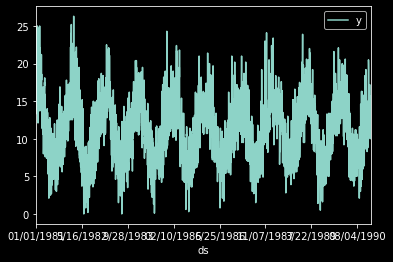

In [1]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import altair as alt

df1 = pd.read_csv('daily-minimum-temperatures-in-me.csv')
df1.plot(x='ds',y='y')

def fit_predict_model(dataframe,mcmc_samples=1000, interval_width = 0.95, changepoint_range = 0.8,n_changepoints=3):
    m = Prophet(daily_seasonality = True, yearly_seasonality = True, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
    
pred = fit_predict_model(df1)

In [5]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df1['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [3]:
pred.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,1981-01-01,4.438191,15.637136,10.493706,20.774446,20.7,0,0.0
1,1981-01-02,4.437354,15.717927,10.447465,20.508126,17.9,0,0.0
2,1981-01-03,4.436517,15.798561,10.316021,21.031745,18.8,0,0.0
3,1981-01-04,4.435680,15.877663,10.799117,21.329879,14.6,0,0.0
4,1981-01-05,4.434843,15.953874,11.011577,21.370669,15.8,0,0.0


In [4]:
def plot_anomalies(forecasted):
    #alt.data_transformers.disable_max_rows()
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#40E0D0').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [6]:
#from fbprophet.diagnostics import cross_validation
#df_cv = cross_validation(m, initial='365 days', period='180 days', horizon = '365 days')
#df_cv.head()

INFO:fbprophet:Making 17 forecasts with cutoffs between 1982-02-11 00:00:00 and 1989-12-31 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1982-02-12,16.462682,12.018378,21.556912,17.0,1982-02-11
1,1982-02-13,16.581187,11.696664,21.861145,19.2,1982-02-11
2,1982-02-14,16.688771,11.727151,21.643134,22.8,1982-02-11
3,1982-02-15,16.780929,11.970847,21.766337,26.3,1982-02-11
4,1982-02-16,16.853433,12.227870,21.618592,18.2,1982-02-11


In [7]:
#from fbprophet.diagnostics import performance_metrics
#df_p = performance_metrics(df_cv)
#df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,coverage
0,37 days,8.576079,2.928494,2.251090,0.934725
1,38 days,8.470843,2.910471,2.241837,0.933966
2,39 days,8.341540,2.888172,2.216252,0.935579
3,40 days,8.229506,2.868712,2.207672,0.938805
4,41 days,8.257523,2.873591,2.217112,0.935484


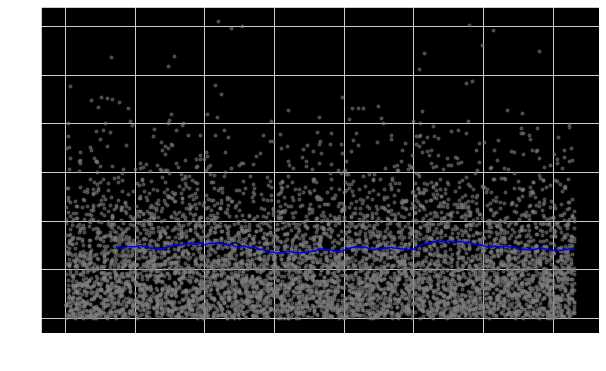

In [8]:
#from fbprophet.plot import plot_cross_validation_metric
#fig = plot_cross_validation_metric(df_cv, metric='rmse')
